In [302]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import scipy
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error 
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
warnings.filterwarnings('ignore')
from sklearn.tree import plot_tree
from sklearn.metrics import r2_score
from scipy.stats import gaussian_kde
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer

In [303]:
# Import Data

# Suppress FutureWarning
warnings.filterwarnings('ignore', category=FutureWarning)

df = pd.read_csv('~/Desktop/Salary_Data.csv')

df

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0
...,...,...,...,...,...,...
6699,49.0,Female,PhD,Director of Marketing,20.0,200000.0
6700,32.0,Male,High School,Sales Associate,3.0,50000.0
6701,30.0,Female,Bachelor's Degree,Financial Manager,4.0,55000.0
6702,46.0,Male,Master's Degree,Marketing Manager,14.0,140000.0


In [304]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6704 entries, 0 to 6703
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  6702 non-null   float64
 1   Gender               6702 non-null   object 
 2   Education Level      6701 non-null   object 
 3   Job Title            6702 non-null   object 
 4   Years of Experience  6701 non-null   float64
 5   Salary               6699 non-null   float64
dtypes: float64(3), object(3)
memory usage: 314.4+ KB


In [305]:
df.describe()

,Age,Years of Experience,Salary
count,6702.000000,6701.000000,6699.000000
mean,33.620859,8.094687,115326.964771
std,7.614633,6.059003,52786.183911
min,21.000000,0.000000,350.000000
25%,28.000000,3.000000,70000.000000
50%,32.000000,7.000000,115000.000000
75%,38.000000,12.000000,160000.000000
max,62.000000,34.000000,250000.000000


In [306]:
df.isnull().sum()

Age                    2
Gender                 2
Education Level        3
Job Title              2
Years of Experience    3
Salary                 5
dtype: int64

In [307]:
df.dropna(inplace=True)

In [311]:
df['Education Level'].value_counts()

Education Level
Bachelor's Degree    2265
Master's Degree      1572
PhD                  1368
Bachelor's            756
High School           448
Master's              288
phD                     1
Name: count, dtype: int64

In [312]:
df['Education Level'].replace(["Bachelor's Degree","Master's Degree","phD"],["Bachelor's","Master's","PhD"],inplace=True)
df['Education Level'].value_counts()

Education Level
Bachelor's     3021
Master's       1860
PhD            1369
High School     448
Name: count, dtype: int64

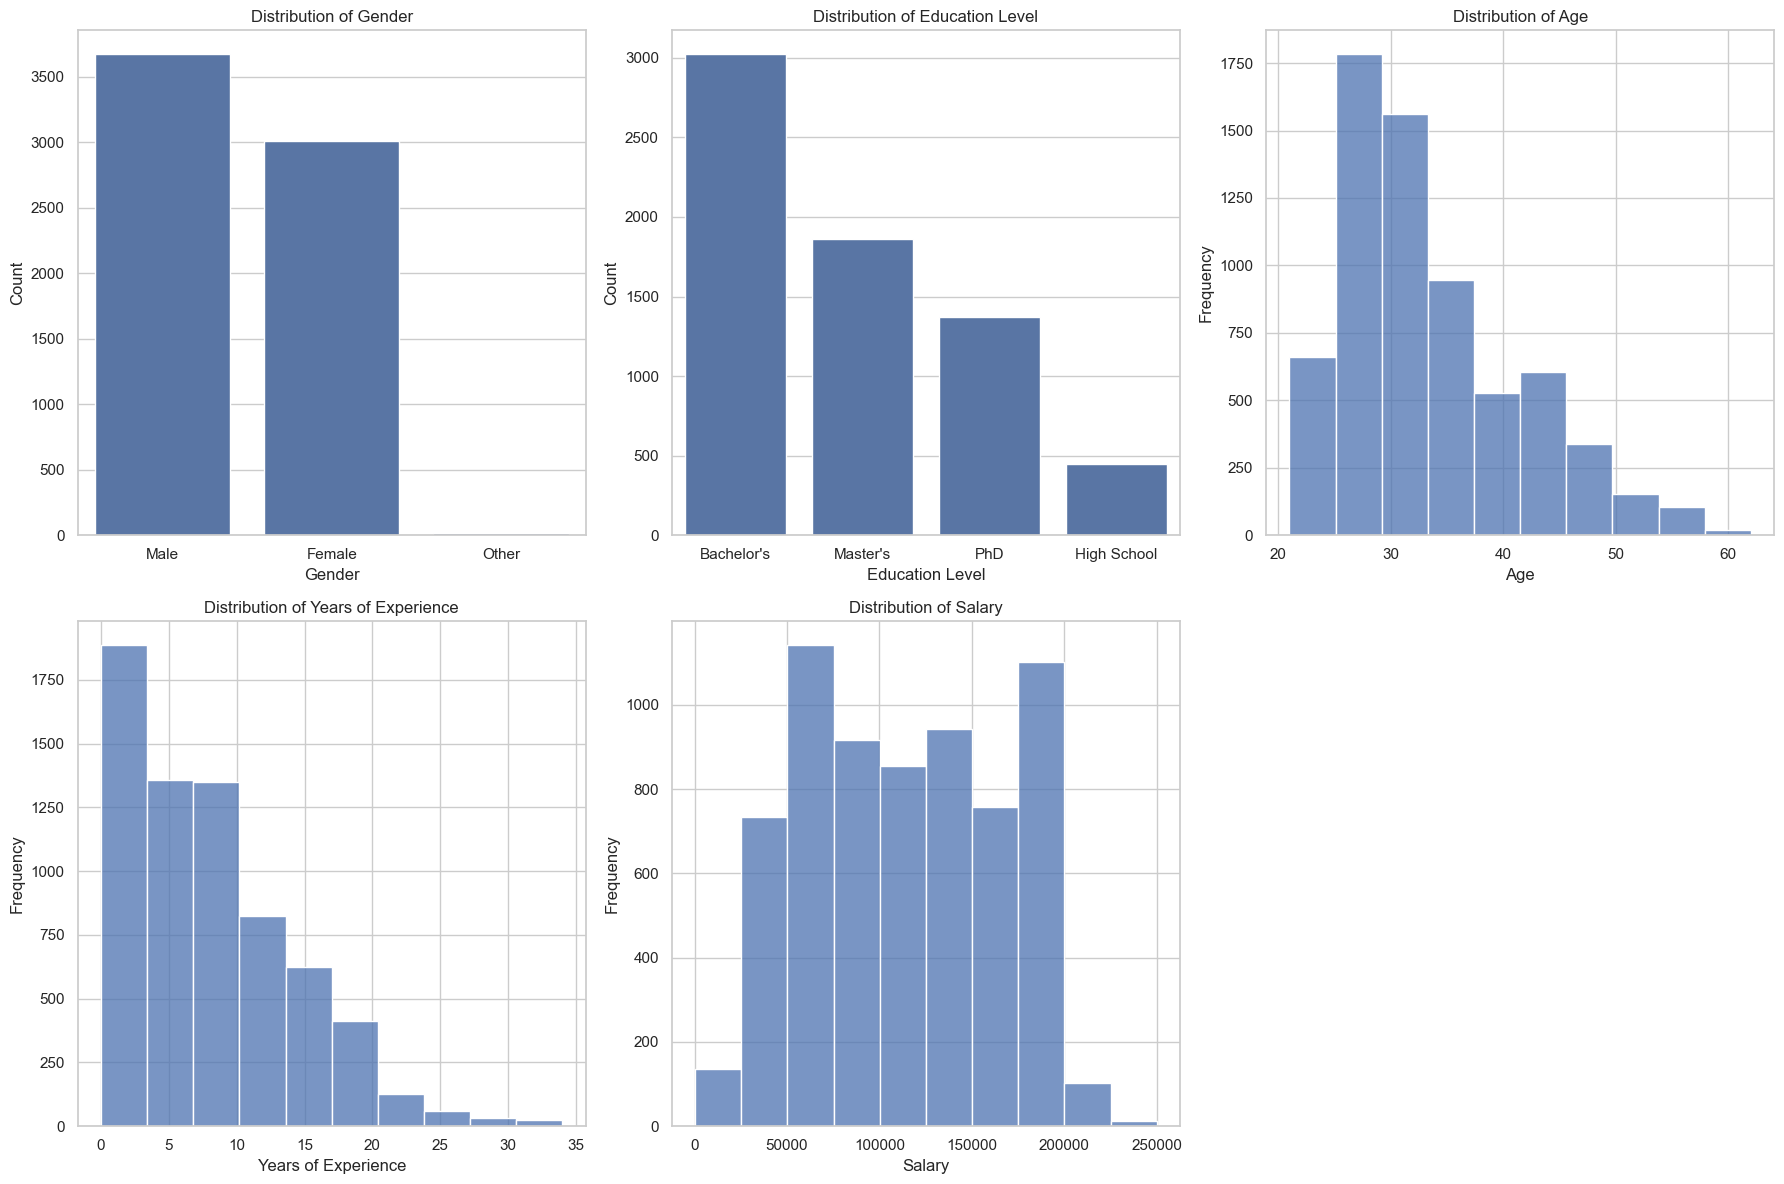

In [313]:

# Create a figure with subplots arranged in a grid
fig, ax = plt.subplots(2, 3, figsize=(18, 12))  # Adjust the layout to fit 5 plots

# Categorical data
sns.countplot(x='Gender', data=df, ax=ax[0, 0])
ax[0, 0].set_title('Distribution of Gender')
ax[0, 0].set_xlabel('Gender')
ax[0, 0].set_ylabel('Count')

sns.countplot(x='Education Level', data=df, ax=ax[0, 1])
ax[0, 1].set_title('Distribution of Education Level')
ax[0, 1].set_xlabel('Education Level')
ax[0, 1].set_ylabel('Count')

# Numerical data
sns.histplot(df['Age'], bins=10, kde=False, ax=ax[0, 2])
ax[0, 2].set_title('Distribution of Age')
ax[0, 2].set_xlabel('Age')
ax[0, 2].set_ylabel('Frequency')

sns.histplot(df['Years of Experience'], bins=10, kde=False, ax=ax[1, 0])
ax[1, 0].set_title('Distribution of Years of Experience')
ax[1, 0].set_xlabel('Years of Experience')
ax[1, 0].set_ylabel('Frequency')

sns.histplot(df['Salary'], bins=10, kde=False, ax=ax[1, 1])
ax[1, 1].set_title('Distribution of Salary')
ax[1, 1].set_xlabel('Salary')
ax[1, 1].set_ylabel('Frequency')

# Hide the unused subplot (bottom right)
ax[1, 2].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()


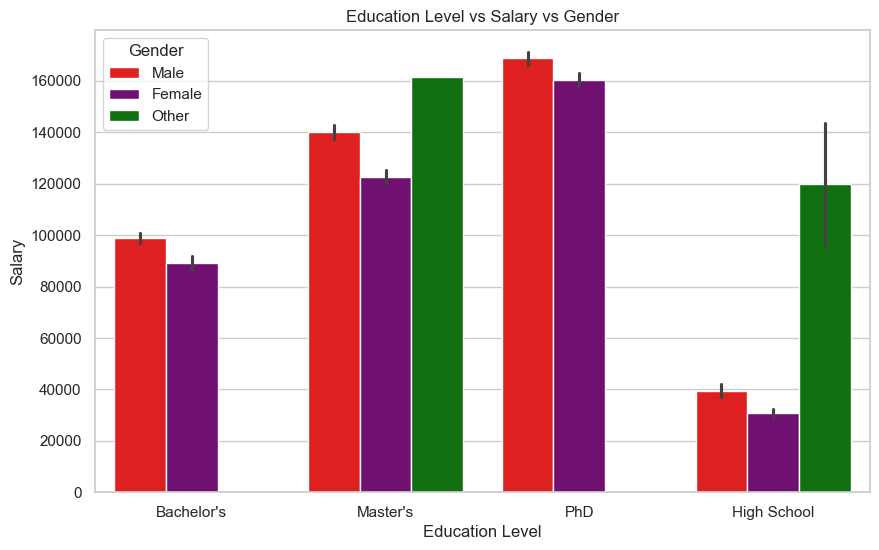

In [314]:
# Define the custom color palette
palette = {"Male": "red", "Female": "purple", "Other": "green"}

# Create a bar plot
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x="Education Level", y="Salary", hue="Gender", data=df, palette=palette)
bar_plot.set_title('Education Level vs Salary vs Gender')
bar_plot.set_xlabel('Education Level')
bar_plot.set_ylabel('Salary')
plt.legend(title='Gender')

# Show the plot
plt.show()


In [315]:
def cleanExtraSpaces(title_val): # get's rid of extra/double whitespace, improves accuracy
    return re.sub(r'\s+', ' ', title_val).strip()

def estimateJobRanking(job_title):
    base_score = 100
    delta = 30
    penalty = ["junior", "intern", "jr", "jr.",  "analyst", "clerk", "associate", "assistant", "specialist", "representative", "coordinator", "support"]
    upgrade = ["director", "manager", "senior", "sr", "sr.", "ceo", "chief", "cto", "vice", "vp", "svp", "avp", "principal", "lead"]
    weights = dict.fromkeys(penalty, -delta)
    weights.update(dict.fromkeys(upgrade, delta))
    return base_score + sum(map(lambda x: weights.get(x, 0), job_title.lower().split(' ')))


df = df[df['Salary'] >= 5000] # drops all salaries less than 5k because that is unreasonable (there was one that was $350)

df['Age'] = df['Age'].astype(int)
df['Years of Experience'] = df['Years of Experience'].astype(int)
df['Salary'] = df['Salary'].astype(int)


df['Job Title'] = df['Job Title'].astype(str)
df['Job Title'] = df['Job Title'].map(cleanExtraSpaces)
df['Job Ranking'] = df['Job Title'].map(estimateJobRanking)
df.drop(['Job Title'], axis=1, inplace=True)


label_encoder = LabelEncoder()
df['Gender'] = label_encoder.fit_transform(df['Gender'])
df['Education Level'] = label_encoder.fit_transform(df['Education Level'])

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


"\ndef scale_features(data, features):\n    scaler = StandardScaler()\n    data[features] = scaler.fit_transform(data[features])\n    return data\n\n# Data loading and processing\ndata = load_and_preprocess_data(data_file_csv)\ndata = scale_features(data, ['Age', 'Years of Experience'])\n\nX = data[['Age', 'Gender', 'Education Level', 'Job Title', 'Years of Experience']]\ny = data['Salary']\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n"

In [316]:
df

,Age,Gender,Education Level,Years of Experience,Salary,Job Ranking
0,32,1,0,5,90000,100
1,28,0,2,3,65000,70
2,45,1,3,15,150000,160
3,36,0,0,7,60000,70
4,52,1,2,20,200000,130
...,...,...,...,...,...,...
6699,49,0,3,20,200000,130
6700,32,1,1,3,50000,70
6701,30,0,0,4,55000,130
6702,46,1,2,14,140000,130


In [317]:
X = df.drop('Salary', axis=1)
y = df['Salary']

In [318]:
# Splitting data into 25% training and 75% test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape


(5355, 5)

**Random Forest**

In [319]:
#Models training and evaluation
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

In [320]:
y_pred_rfr = rf.predict(X_test)

print("Mean Absolute Error :",mean_absolute_error(y_test,y_pred_rfr))
print(f"Random Forest MSE: {mse_rf}, R2: {r2_rf}")

Mean Absolute Error : 5777.685090838187
Random Forest MSE: 134656584.6099088, R2: 0.950701604217655


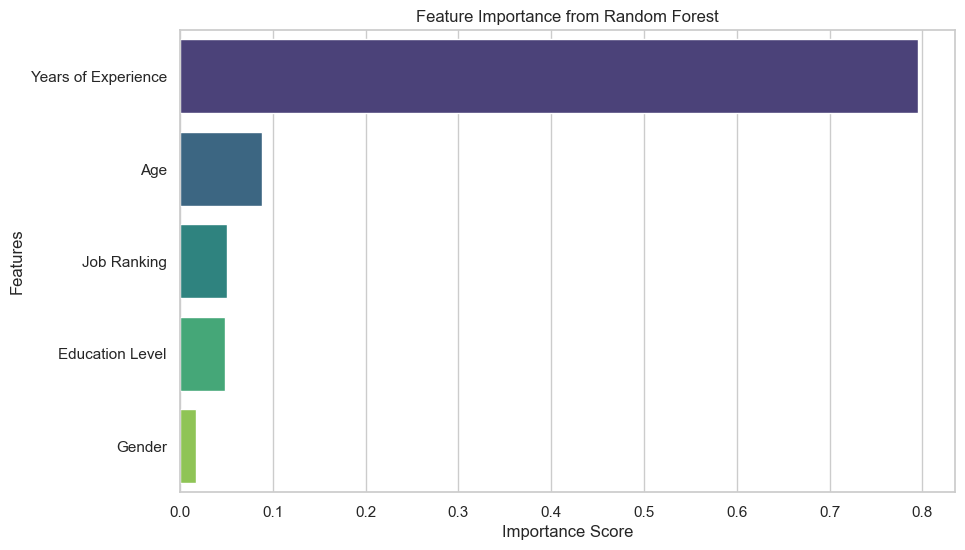

In [321]:
# Visualizations
sns.set(style="whitegrid")
feature_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.values, y=feature_importance.index, palette='viridis')
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()



**Decision Tree**

In [322]:
 # Decision Tree model
dtr = DecisionTreeRegressor(max_depth=10,min_samples_split=2,random_state=0)
dtr.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=10, random_state=0)

In [323]:
y_pred_dtr = dtr.predict(X_test)

In [324]:
#Model Evaluation
mae = mean_absolute_error(y_test, y_pred_dtr)
print("Mean Absolute Error:", mae)


mse = mean_squared_error(y_test, y_pred_dtr)
print("Mean Squared Error:", mse)

r2 = r2_score(y_test, y_pred_dtr)
print("R-squared error:", r2)

Mean Absolute Error: 7477.961432620228
Mean Squared Error: 193711310.81266862
R-squared error: 0.9290813969801439


In [325]:
#Inputting my own values 
output = dtr.predict([[36, 0, 0, 7, estimateJobRanking('Sales Associate')]])
try:
    print("Salary prediction is", int(output[0]))
except:
    print("Error: prediction was not possible.")

Salary prediction is 60000


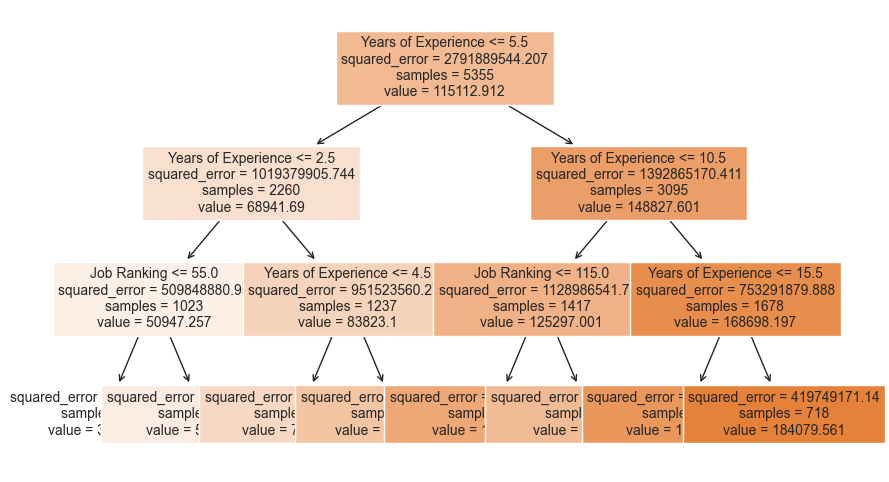

In [326]:
# DecisionTreeRegressor with max_depth parameter
model = DecisionTreeRegressor(max_depth=3, random_state=42)

# Fit the model using training data
model.fit(X_train, y_train)

# Plot the decision tree
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plot_tree(model, feature_names=X.columns, filled=True, fontsize=10)
plt.show()

**Linear Regression**

In [327]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [328]:
lr.score(X_test,y_test)

0.6778093538131824

In [342]:
y_pred_lr = lr.predict(X_test)

print("Mean Squared Error :",mean_squared_error(y_test,y_pred_lr))
print("Mean Absolute Error :",mean_absolute_error(y_test,y_pred_lr))
print("Root Mean Squared Error :",mean_squared_error(y_test,y_pred_lr,squared=False))

Mean Squared Error : 7551512119.432695
Mean Absolute Error : 85905.51315394301
Root Mean Squared Error : 86899.4368188465


**SVM**

In [330]:
svm = SVR(kernel='rbf', C=1.0, epsilon=0.2)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
mse_svm = mean_squared_error(y_test, y_pred_svm)
r2_svm = r2_score(y_test, y_pred_svm)


In [332]:
print(f"SVM MSE: {mse_svm}, R2: {r2_svm}")
mae = mean_absolute_error(y_test, y_pred_svm)
print("Mean Absolute Error:", mae)

SVM MSE: 2715052962.511721, R2: 0.006006606333591846
Mean Absolute Error: 44627.65368688401


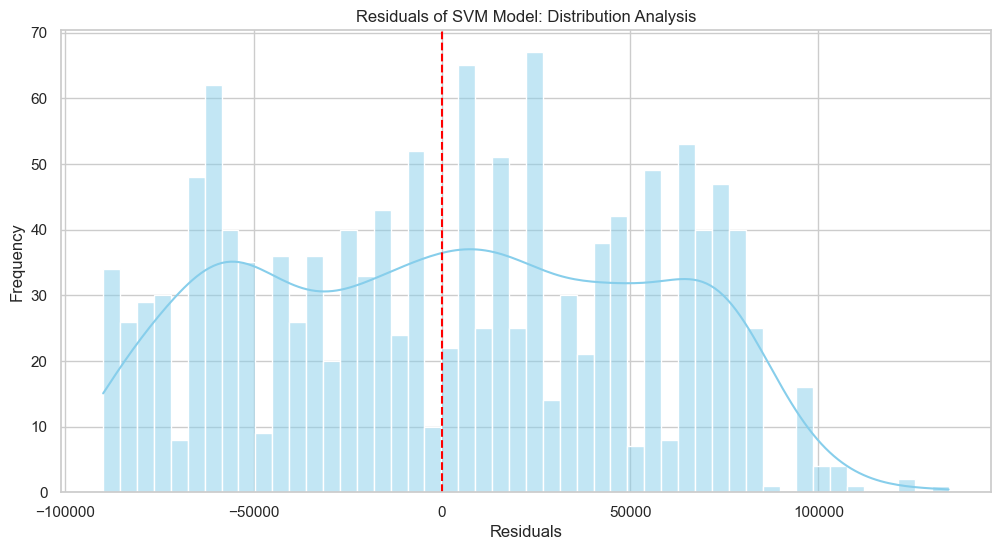

In [333]:
#Redisuals plot SVM
residuals = y_test - y_pred_svm
plt.figure(figsize=(12, 6))
sns.histplot(residuals, bins=50, kde=True, color='skyblue')
plt.title('Residuals of SVM Model: Distribution Analysis')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.axvline(x=0, color='red', linestyle='--')
plt.show()


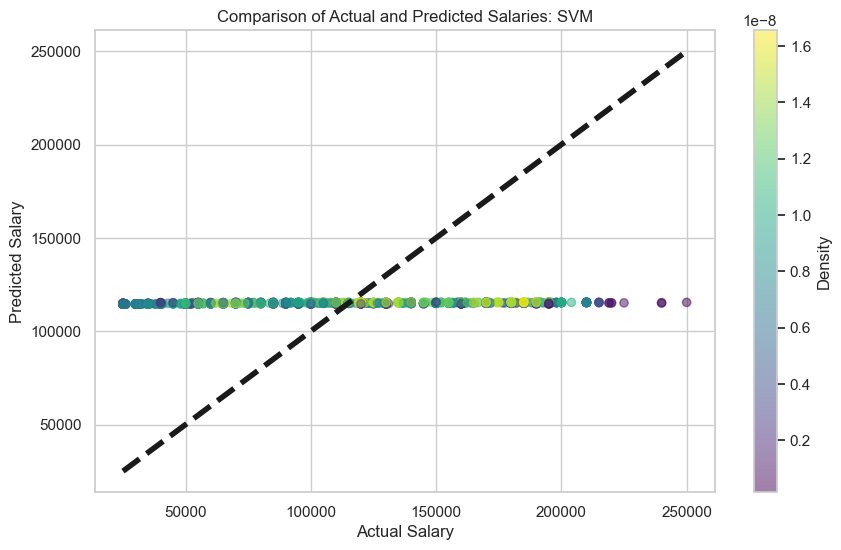

In [334]:
# Density calculation for scatter plot
x = y_test
y = y_pred_svm
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x, y, c=z, cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Density')
plt.title('Comparison of Actual and Predicted Salaries: SVM')
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.plot([x.min(), x.max()], [x.min(), x.max()], 'k--', lw=4)
plt.show()

In [335]:
# Logistic Regression

# Define a binary target variable: 1 if salary is above median, 0 otherwise
median_salary = df['Salary'].median()
df['Above Median Salary'] = (df['Salary'] > median_salary).astype(int)

# Drop the original 'Salary' column
df.drop('Salary', axis=1, inplace=True)

# Label encode categorical variables
label_encoders = {}
for column in ['Gender', 'Education Level', 'Job Ranking']:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])

# Split the data into features and target variable
X = df.drop('Above Median Salary', axis=1)
y = df['Above Median Salary']

# Check for missing values
print(df.isnull().sum())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Print shapes for debugging
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# Train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))



Age                    0
Gender                 0
Education Level        0
Years of Experience    0
Job Ranking            0
Above Median Salary    0
dtype: int64
X_train shape: (5355, 5)
y_train shape: (5355,)
Accuracy: 0.8603435399551904
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       656
           1       0.88      0.85      0.86       683

    accuracy                           0.86      1339
   macro avg       0.86      0.86      0.86      1339
weighted avg       0.86      0.86      0.86      1339



In [336]:
# Feature of Importance

# Extract feature names
feature_names = X.columns

# Extract coefficients from the model
coefficients = model.coef_[0]

# Create a DataFrame to store feature names and their coefficients
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the DataFrame by absolute coefficient values
feature_importance['Absolute Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Absolute Coefficient', ascending=False)

# Display the feature importance
print(feature_importance)

               Feature  Coefficient  Absolute Coefficient
3  Years of Experience     6.453322              6.453322
0                  Age    -2.635399              2.635399
4          Job Ranking    -0.398364              0.398364
1               Gender     0.227929              0.227929
2      Education Level     0.191571              0.191571


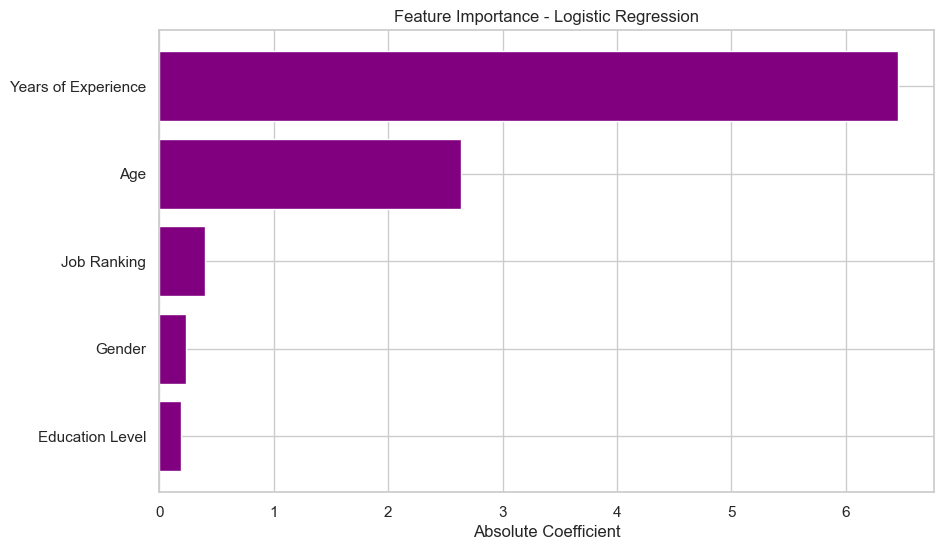

In [337]:
# Create a bar plot to visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Absolute Coefficient'], color='purple')
plt.xlabel('Absolute Coefficient')
plt.title('Feature Importance - Logistic Regression')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

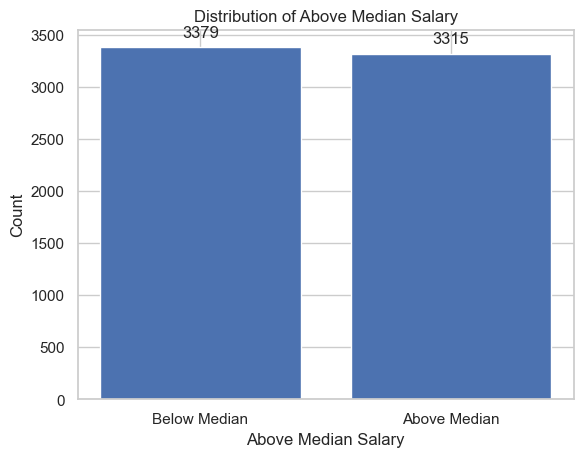

In [338]:
# Count the occurrences of each class
class_counts = df['Above Median Salary'].value_counts()

# Plot the bar chart
plt.bar(class_counts.index, class_counts.values)

# Add labels and title
plt.xlabel('Above Median Salary')
plt.ylabel('Count')
plt.title('Distribution of Above Median Salary')

# Add annotation for each bar
for i, count in enumerate(class_counts.values):
    plt.text(i, count + 100, str(count), ha='center')

# Show the plot
plt.xticks([0, 1], ['Below Median', 'Above Median'])
plt.show()

In [340]:
# Initialize and fit logistic regression model
model = LogisticRegression()
model.fit(age.values.reshape(-1, 1), salary)

# Predict probabilities
age_range = np.linspace(age.min(), age.max(), 100).reshape(-1, 1)
probabilities = model.predict_proba(age_range)[:, 1]

# Plot scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(age, salary, alpha=0.5, color='blue')

# Plot curve line
plt.plot(age_range, probabilities, color='red')

# Adding labels and title
plt.title('Salary vs Age')
plt.xlabel('Age')
plt.ylabel('Above Median Salary')

# Show plot
plt.show()

NameError: name 'age' is not defined

<h2>Results<h2>

Random Forest model performed the best with the lowest MAE and lowest MSE, making it the best model for predicting salaries. 
